# Plotting and validating the TCN model to make it ready for scenario modeling

In [213]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [214]:
import sys
sys.path.append('../src')

In [215]:
from darts import TimeSeries
import pandas as pd
from definitions import TARGETS
import matplotlib.pyplot as plt

MEAS_COLUMNS = [
    "TI-19",
#      "FI-16",
#     "TI-33",
#     "FI-2",
#     "FI-151",
#     "TI-8",
#     "FI-241",
#  "valve-position-12",  # dry-bed
#     "FI-38",  # strippera
#     "PI-28",  # stripper
    
#     "TI-28",  # stripper
#      "FI-20",
#     "FI-30",
    "TI-3",
    "FI-19",
#     "FI-211",
    "FI-11",
#     "TI-30",
#     "PI-30",
    "TI-1213",
#     "TI-4",
    "FI-23",
    "FI-20",
    "FI-20/FI-23",
#    "TI-22",
    "delta_t",
    "TI-35",
    "delta_t_2"
]

TARGETS_clean = ['2-Amino-2-methylpropanol C4H11NO', 'Piperazine C4H10N2', 
                 "Carbon dioxide CO2", "Ammonia NH3"]



In [216]:
from pyprocessta.model.tcn import transform_data, run_model, parallelized_inference
from pyprocessta.preprocess.resample import resample_regular

In [217]:
import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use('science')
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'

In [218]:
df = pd.read_pickle('20210508_df_cleaned.pkl')

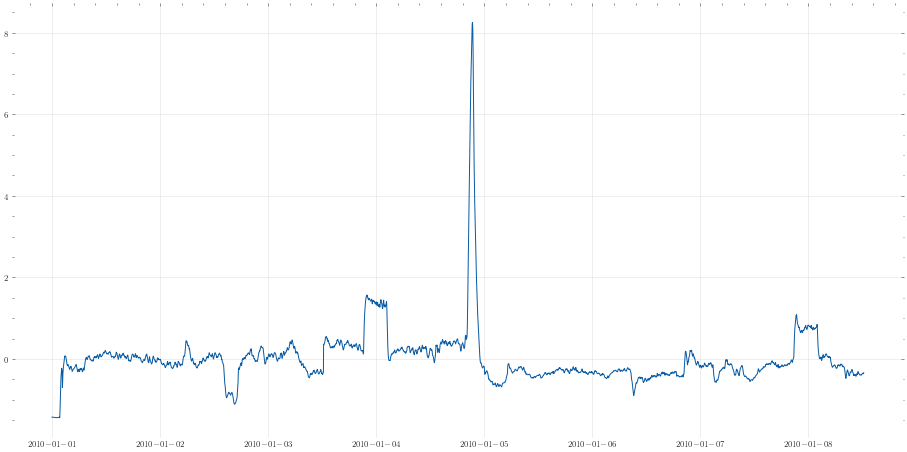

In [219]:
plt.figure(figsize=(16,8))
plt.plot(df[TARGETS[0]])

In [220]:
TARGETS

['Carbon dioxide CO2',
 '2-Amino-2-methylpropanol C4H11NO',
 'Piperazine C4H10N2',
 'Ammonia NH3']

In [221]:
TARGETS_clean = ['2-Amino-2-methylpropanol C4H11NO', 'Piperazine C4H10N2']

In [222]:
y = TimeSeries.from_dataframe(df, value_cols=TARGETS_clean)
x = TimeSeries.from_dataframe(df, value_cols=MEAS_COLUMNS)

In [223]:
def split_data(x, y, timestamp):
    x_before, x_after = x.split_before(pd.Timestamp(timestamp))
    y_before, y_after = y.split_before(pd.Timestamp(timestamp))
    
    return (x_before, y_before), (x_after, y_after)

In [224]:
before, after  = split_data(x,y, '5-Jan-2010 23:00')

In [225]:
len(before[0])

3570

In [226]:
train_tuple, test_tuple, scalers = transform_data(before, [after])
model = run_model(train_tuple)

[2021-05-16 17:23:50,014] INFO | darts.models.torch_forecasting_model | Train dataset contains 3501 samples.
[2021-05-16 17:23:50,014] INFO | darts.models.torch_forecasting_model | Train dataset contains 3501 samples.


(1839, 11) (1839, 2)


In [227]:
x_test, y_test = test_tuple[0]

In [228]:
x_train, y_train = train_tuple

In [229]:
x_connected = TimeSeries.from_dataframe(pd.concat([x_train.pd_dataframe(), x_test.pd_dataframe()]))

In [230]:
y_connected = TimeSeries.from_dataframe(pd.concat([y_train.pd_dataframe(), y_test.pd_dataframe()]))

In [231]:
backtest = model.historical_forecasts(y_connected,
                          covariates=x_connected,
                          start=0.1,
                          forecast_horizon=10,
                          stride=1,
                          retrain=False,
                          verbose=False)

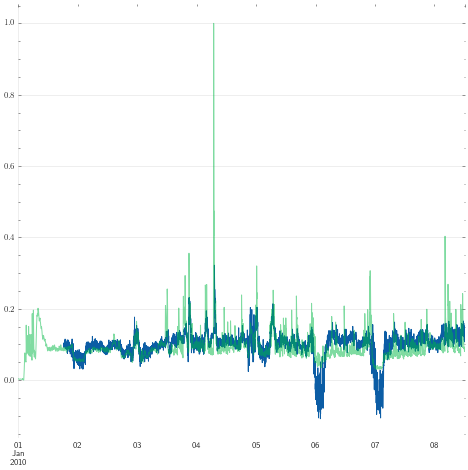

In [232]:
plt.figure(figsize=(8,8))
backtest['1'].plot()
y_connected['1'].plot(alpha=.5)

In [ ]:
results = parallelized_inference(model, x_connected, y_connected, repeats=10, start=0.1)

In [110]:
len(results)

100

In [54]:
import pickle

In [ ]:
with open('results.pkl', 'wb') as handle: 
    pickle.dump(results, handle)

In [178]:
import numpy as np

In [179]:
def summarize_results(results): 
    values = []
    
    for df in results: 
        values.append(df.pd_dataframe().values)
    
    df = df.pd_dataframe()
    columns = df.columns
    
    return pd.DataFrame(np.mean(values, axis=0), columns=columns, index=df.index), pd.DataFrame(np.std(values, axis=0), columns=columns,  index=df.index)

In [180]:
means, stds = summarize_results(results)

(0.01, 0.06)

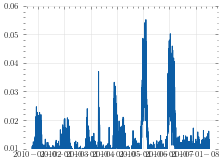

In [181]:
plt.plot(stds['0'])
plt.ylim(0.01,0.06)

In [182]:
import matplotlib.dates as md

In [183]:

y_connected_df = y_connected.pd_dataframe()
x_axis = means['1'].index - y_connected_df['1'].index[0]
x = [val.total_seconds() / (60 * 60 * 24) for val in x_axis]
x_conncected = y_connected_df['1'].index - y_connected_df['1'].index[0]
x_conncected = [val.total_seconds() / (60 * 60 * 24) for val in x_conncected]

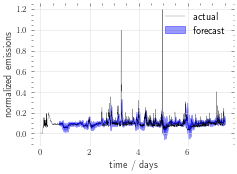

In [184]:
plt.plot(x, means['1'], c='b',  alpha=.9, lw=.2)
plt.fill_between(x,means['1']-2*stds['1'], means['1']+2*stds['1'], alpha=.4, color='b', label='forecast',)
plt.plot(x_conncected, y_connected_df['1'], c='k', label='actual', lw=.2,)

plt.legend()
plt.vlines(x_conncected[3570], 0,1.2, color='gray')
#plt.xticks([])

plt.xlabel('time / days')
plt.ylabel('normalized emissions')
plt.tight_layout()
plt.savefig('piperazine_forecast.pdf', bbox_inches='tight')

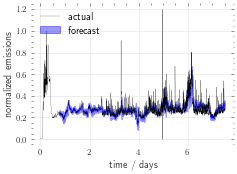

In [185]:
plt.plot(x, means['0'], c='b',  alpha=.9, lw=.2)
plt.fill_between(x,means['0']-2*stds['0'], means['0']+2*stds['0'], alpha=.4, color='b', label='forecast',)
plt.plot(x_conncected, y_connected_df['0'], c='k', label='actual', lw=.2, alpha=1)

plt.legend(loc='upper left')
plt.vlines(x_conncected[3570], 0,1.2, color='gray')
#plt.xticks([])

plt.xlabel('time / days')
plt.ylabel('normalized emissions')
plt.tight_layout()
plt.savefig('2amp_forecast.pdf', bbox_inches='tight')

## Predict ammonia and CO2

In [118]:
TARGETS_clean_co2 = ['Ammonia NH3', 'Carbon dioxide CO2']

In [119]:
y_co2 = TimeSeries.from_dataframe(df, value_cols=TARGETS_clean_co2)
x = TimeSeries.from_dataframe(df, value_cols=MEAS_COLUMNS)

In [120]:
before_co2, after_co2  = split_data(x, y_co2, '4-Jan-2010 23:00')

In [121]:
train_tuple_co2, test_tuple_co2, scalers_co2 = transform_data(before_co2, [after_co2])
model_co2 = run_model(train_tuple_co2)

[2021-05-15 02:51:59,233] INFO | darts.models.torch_forecasting_model | Train dataset contains 2805 samples.
[2021-05-15 02:51:59,233] INFO | darts.models.torch_forecasting_model | Train dataset contains 2805 samples.


(2559, 11) (2559, 2)


In [122]:
x_test_co2, y_test_co2 = test_tuple_co2[0]

In [123]:
x_train_co2, y_train_co2 = train_tuple_co2

In [124]:
x_connected_co2 = TimeSeries.from_dataframe(pd.concat([x_train_co2.pd_dataframe(), x_test_co2.pd_dataframe()]))

In [125]:
y_connected_co2 = TimeSeries.from_dataframe(pd.concat([y_train_co2.pd_dataframe(), y_test_co2.pd_dataframe()]))

In [126]:
results_co2 = parallelized_inference(model_co2, x_connected_co2, y_connected_co2, repeats=100, start=0.1)

In [127]:
means_co2, stds_co2 = summarize_results(results_co2)

In [128]:
y_connected_co2_df = y_connected_co2.pd_dataframe()

In [129]:
x_axis = means['1'].index - y_connected_co2_df['1'].index[0]
x = [val.total_seconds() / (60 * 60 * 24) for val in x_axis]
# y_connected_df = y_connected.pd_dataframe()
x_connected_co2 = y_connected_co2_df['1'].index - y_connected_co2_df['1'].index[0]
x_connected_co2 = [val.total_seconds() / (60 * 60 * 24) for val in x_connected_co2]

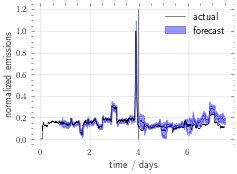

In [130]:
plt.plot(x, means_co2['1'], c='b',  alpha=.9, lw=.2)
plt.fill_between(x,means_co2['1']-2*stds_co2['1'], means_co2['1']+2*stds_co2['1'], alpha=.4, color='b', label='forecast',)
plt.plot(x_connected_co2, y_connected_co2_df['1'], c='k', label='actual', lw=.5)

plt.legend()
plt.vlines(x_connected_co2[2850], 0,1.2, color='gray')
#plt.xticks([])

plt.xlabel('time / days')
plt.ylabel('normalized emissions')
plt.tight_layout()
plt.savefig('co2_forecast.pdf', bbox_inches='tight')

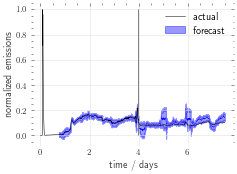

In [131]:
plt.plot(x, means_co2['0'], c='b',  alpha=.9, lw=.2)
plt.fill_between(x,means_co2['0']-2*stds_co2['0'], means_co2['0']+2*stds_co2['0'], alpha=.4, color='b', label='forecast',)
plt.plot(x_connected_co2, y_connected_co2_df['0'], c='k', label='actual', lw=.5)

plt.legend()
plt.vlines(x_connected_co2[2850], 0,1.0, color='gray')
#plt.xticks([])

plt.xlabel('time / days')
plt.ylabel('normalized emissions')
plt.tight_layout()
plt.savefig('nh3_forecast.pdf', bbox_inches='tight')